In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth



In [5]:
import pandasql as ps

In [ ]:
#crear conexion con la api de spotify
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id="your cliente_id",
    client_secret="your client secret",
    redirect_uri="http://localhost:8888/callback",
    scope="playlist-read-private"
))


In [30]:
#verificamos buscando un atista
nombre_artista='Bad Bunny'
resultado = sp.search(q='artist ' + nombre_artista, type = 'artist')
artistas = resultado['artists']['items']
lista_artistas = []

for artista in artistas:
    nombre = artista['name']
    popularidad= artista['popularity']
    seguidores = artista['followers']['total']
    lista_artistas.append([nombre,popularidad,seguidores])


In [31]:
#lo pasamos a un dataframe
df_artistas = pd.DataFrame(lista_artistas, columns = ['nombre','popularidad','seguidores'])
df_artistas.head(10)

,nombre,popularidad,seguidores
0,Kendo Kapponi,51,4748
1,Bad Buaay,3,2
2,PRESSURE,47,14925
3,Humby,44,70
4,GRANDE,44,5025
5,UGUESS,32,11
6,Guty,29,140
7,SAMULX,29,124
8,LEANDRO,29,6373
9,Rulaz Plazco,28,106


In [ ]:
from bs4 import BeautifulSoup 
import requests

ya que el proceso de la extracion de la informacion de las playlist fallo con la api, al parecer las playlist de autoria spotify no se pueden consultar 

con estos metodos de la API

se realiza un webscraping para extraer los ids de las canciones que conforman las playlist del top50 mas sonado de los paises

pero con este metodo solo podremos consultar las primeras 30

y ya con los ids se extrae con otro metodo de la api la informacion de cada cancion y la cargamos a un dataframe

https://developer.spotify.com/documentation/web-api/reference/get-track

In [ ]:
#lista de la playlist de los paises latinoamaricanos
top50 = { 
    'Colombia' :'https://open.spotify.com/playlist/37i9dQZEVXbOa2lmxNORXQ',
    'Mexico':'https://open.spotify.com/playlist/37i9dQZEVXbO3qyFxbkOE1',
    'Chile': 'https://open.spotify.com/playlist/37i9dQZEVXbL0GavIqMTeb',
    'Argentina' :'https://open.spotify.com/playlist/37i9dQZEVXbMMy2roB9myp',
    'Brasil' :'https://open.spotify.com/playlist/37i9dQZEVXbMXbN3EUUhlg',
    'Bolivia' : 'https://open.spotify.com/playlist/37i9dQZEVXbJqfMFK4d691',
    'Ecuador' : 'https://open.spotify.com/playlist/37i9dQZEVXbJlM6nvL1nD1',
    'Peru' : 'https://open.spotify.com/playlist/37i9dQZEVXbJfdy5b0KP7W'
}

In [ ]:

#extraemos una lista con los ids de las canciones que componen las playlist por pais
country_id = {}

for pais,url in top50.items():
    html=requests.get(url)
    soup = BeautifulSoup(html.text, "html5lib")
    html_songs = soup.find_all('meta',{"name": "music:song"})
    urls_song = [urls['content'] for urls in html_songs]
    ids= [id.split('/')[4] for id in urls_song]
    country_id[pais] = ids
    
    
    


In [110]:


#con los ids y la api de spotify extraemos la informacion de cada pais y los guardamos en un dataframe
tracks_data = []

for country, songs_id in country_id.items():
    print(country)
    
    for i, item in enumerate(songs_id):
        results = sp.track(item)
        track_info = {
            'posicion': i +1,
            'nombre_de_la_cancion' : results['name'],
            'Artista(s)' : ', '.join([artist['name'] for artist in results['artists']]),
            'Popularidad' : results['popularity'],
            'Pais' : country
        }
        tracks_data.append(track_info)

df_top50 = pd.DataFrame(tracks_data)

Colombia
Mexico
Chile
Argentina
Brasil
Bolivia
Ecuador
Peru


In [111]:
df_top50.head()


,posicion,nombre_de_la_cancion,Artista(s),Popularidad,Pais
0,1,BAILE INoLVIDABLE,Bad Bunny,95,Colombia
1,2,Mi Refe,"Beéle, Ovy On The Drums",86,Colombia
2,3,DtMF,Bad Bunny,98,Colombia
3,4,CRUZ,"Trueno, Feid",74,Colombia
4,5,VOY A LLeVARTE PA PR,Bad Bunny,93,Colombia


In [115]:
df_top50.to_csv('top_tracks_latam.csv',index=False)

In [112]:
query = """
SELECT * FROM df_top50
WHERE Pais IN ('Colombia','Mexico')
AND Posicion IN (1,2,3,4,5)
ORDER BY pais,Posicion
"""
top_5_sql = ps.sqldf(query,locals())
print(top_5_sql)

   posicion  nombre_de_la_cancion                         Artista(s)  \
0         1     BAILE INoLVIDABLE                          Bad Bunny   
1         2               Mi Refe            Beéle, Ovy On The Drums   
2         3                  DtMF                          Bad Bunny   
3         4                  CRUZ                       Trueno, Feid   
4         5  VOY A LLeVARTE PA PR                          Bad Bunny   
5         1                  Loco                         Neton Vega   
6         2                7 Dias  Gabito Ballesteros, Tito Double P   
7         3               ROSONES                      Tito Double P   
8         4                  DtMF                          Bad Bunny   
9         5                 NADIE                      Tito Double P   

   Popularidad      Pais  
0           95  Colombia  
1           86  Colombia  
2           98  Colombia  
3           74  Colombia  
4           93  Colombia  
5           90    Mexico  
6           81    

In [114]:
query = """
SELECT pais,nombre_de_la_cancion  
FROM df_top50
WHERE Posicion IN (1,2,3,4,5)
ORDER BY pais,Posicion
"""
top_5_sql = ps.sqldf(query,locals())
print(top_5_sql)

         Pais                nombre_de_la_cancion
0   Argentina                   BAILE INoLVIDABLE
1   Argentina                       Parte & Choke
2   Argentina                        Amor de Vago
3   Argentina                                DtMF
4   Argentina                VOY A LLeVARTE PA PR
5     Bolivia                   BAILE INoLVIDABLE
6     Bolivia                                DtMF
7     Bolivia                                Khé?
8     Bolivia                VOY A LLeVARTE PA PR
9     Bolivia                       Parte & Choke
10     Brasil                             Fui Mlk
11     Brasil  Oh Garota Eu Quero Você Só Pra Mim
12     Brasil                 Sei Que Tu Me Odeia
13     Brasil                 Penélope Charmosa 2
14     Brasil                  Resenha do Arrocha
15      Chile                VOY A LLeVARTE PA PR
16      Chile                   BAILE INoLVIDABLE
17      Chile                                DtMF
18      Chile                               VeLDÁ


**Visualizaciones**

In [2]:
top_latam_tracks = pd.read_csv('top_tracks_latam.csv')

In [4]:
top5= top_latam_tracks.sort_values(by='Popularidad', ascending= False)
top5 = top5.drop_duplicates(subset='nombre_de_la_cancion')
top5= top5.head(5)
top5

,posicion,nombre_de_la_cancion,Artista(s),Popularidad,Pais
222,13,Die With A Smile,"Lady Gaga, Bruno Mars",99,Peru
62,3,DtMF,Bad Bunny,98,Chile
230,21,BIRDS OF A FEATHER,Billie Eilish,96,Peru
90,1,BAILE INoLVIDABLE,Bad Bunny,95,Argentina
11,12,NUEVAYoL,Bad Bunny,94,Colombia


<function matplotlib.pyplot.show(close=None, block=None)>

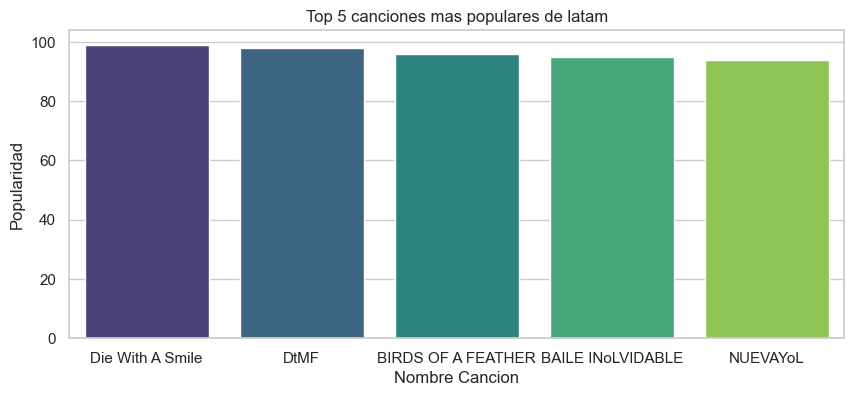

In [18]:
sns.set(style='whitegrid')
plt.figure(figsize = (10,4))
bar_plot = sns.barplot(data = top5, x='nombre_de_la_cancion' , y='Popularidad', hue= 'nombre_de_la_cancion', palette='viridis', legend=False)
plt.xlabel('Nombre Cancion')
plt.ylabel('Popularidad')
plt.title('Top 5 canciones mas populares de latam')
plt.show

Artistas con mas apariciones en los top  

In [20]:
Artista_conteo = top_latam_tracks['Artista(s)'].value_counts().reset_index()
Artista_conteo.columns =['Artista(s)','Apariciones']
top10_artistas = Artista_conteo.head(10)

<function matplotlib.pyplot.show(close=None, block=None)>

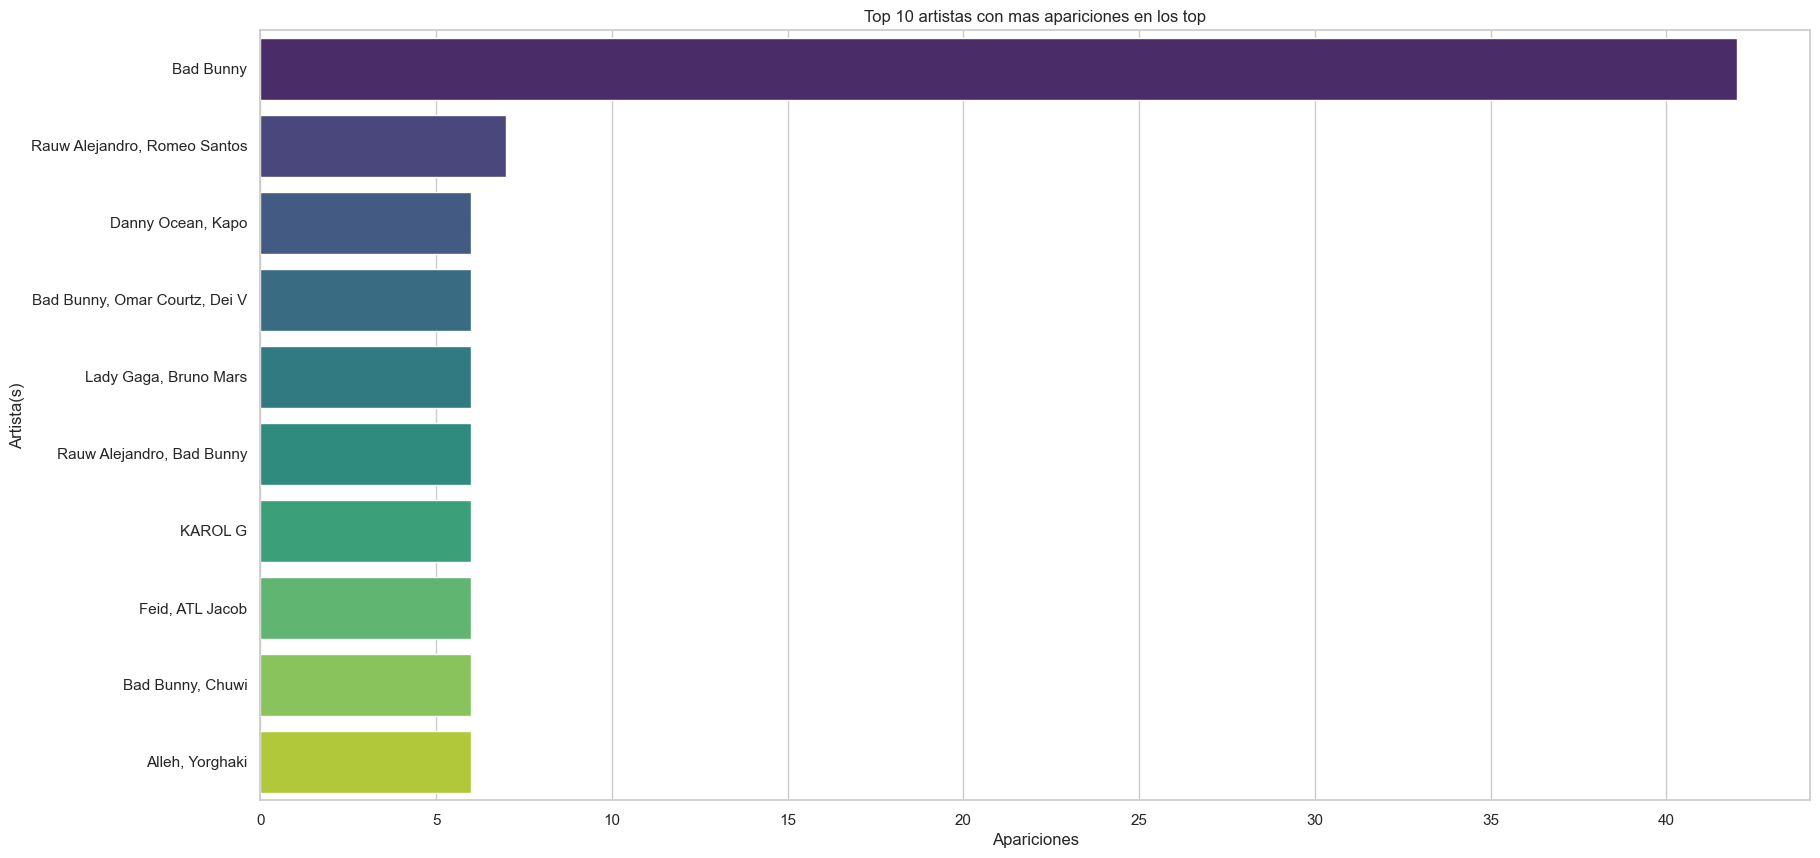

In [25]:
plt.figure(figsize=(20,10))
bar_plot = sns.barplot(data = top10_artistas, x='Apariciones' , y='Artista(s)', hue= 'Artista(s)', palette='viridis', legend=False)
plt.xlabel('Apariciones')
plt.ylabel('Artista(s)')
plt.title('Top 10 artistas con mas apariciones en los top')
plt.show

Artistas con mas canciones en el top

In [43]:
canciones_unicas = top_latam_tracks.drop_duplicates(subset='nombre_de_la_cancion')
conteo = canciones_unicas['Artista(s)'].value_counts().reset_index()
conteo.columns =['Artista(s)','numero_de_canciones']
top10_artistas = conteo.head(10)

<function matplotlib.pyplot.show(close=None, block=None)>

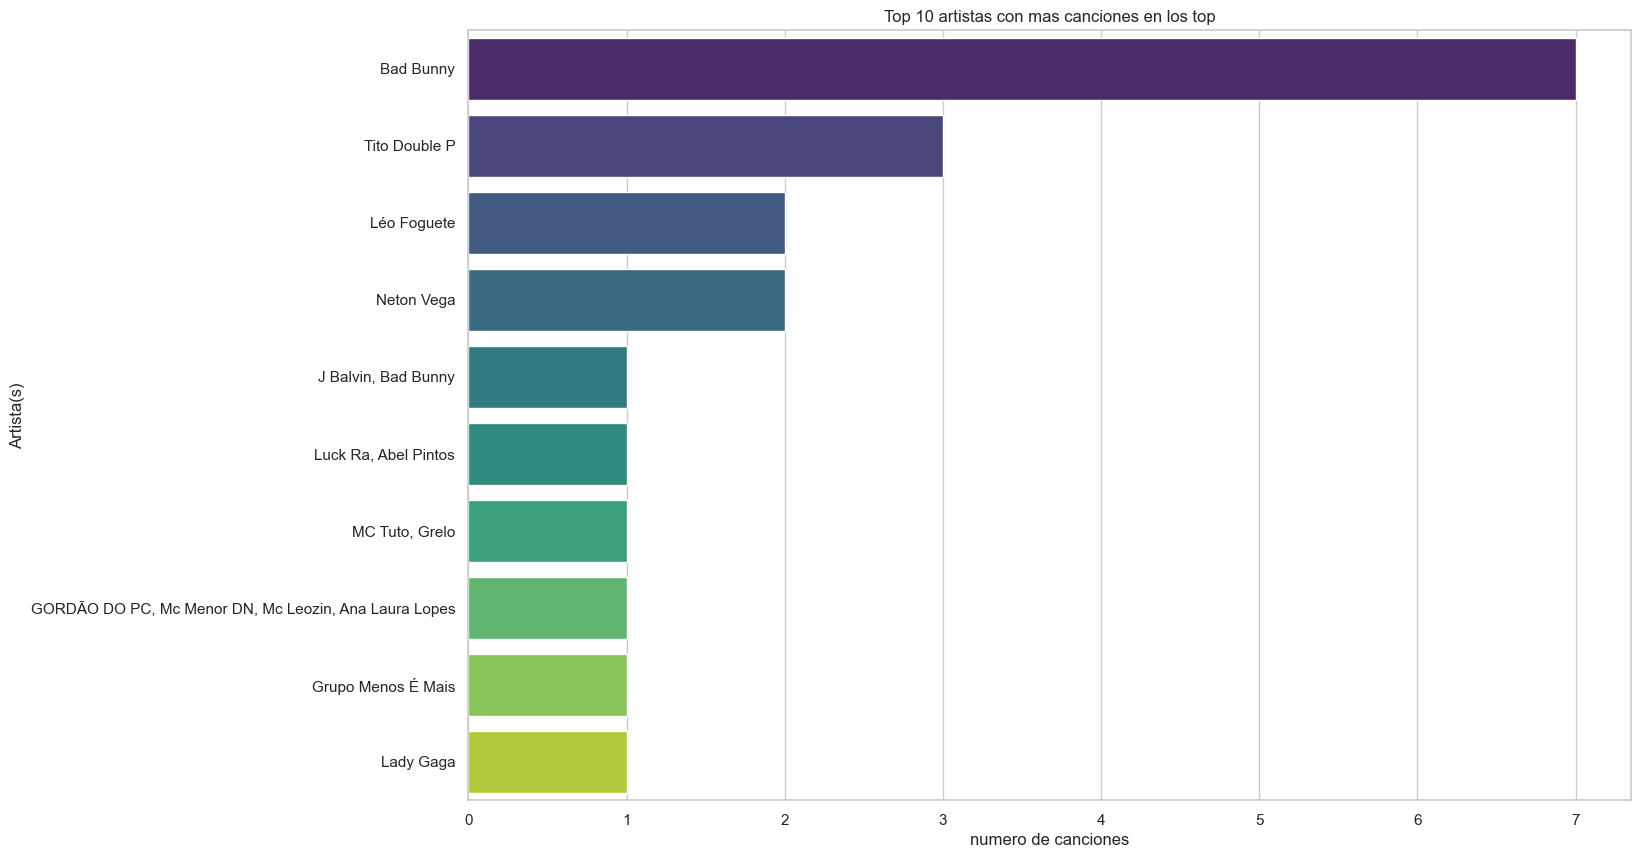

In [32]:
plt.figure(figsize=(15,10))
bar_plot = sns.barplot(data = top10_artistas, x='numero_de_canciones' , y='Artista(s)', hue= 'Artista(s)', palette='viridis', legend=False)
plt.xlabel('numero de canciones')
plt.ylabel('Artista(s)')
plt.title('Top 10 artistas con mas canciones en los top')
plt.show